<h1><center>Public Sentiments on Johnny Depp and Amber Heard Trial</center></h1>

## Introduction and background on research focus
In the recent months, the name of famous actors, Johnny Depp and Amber Heard, has been making headlines in respect to the defamation trials that had been ongoing from the mid of April to the start of June. This gave rise to many different opinions on social media regarding the topic. The overwhelming news coverage and buzz on social media eventually caught my attention, to which I then went on to catch a live stream of the trial.

As I was watching the livestream, a social media analyst, Ron Schnell, presented himself to the court and testified in the trial. He went on to provide an analysis of the activities ongoing on Twitter such as trending hashtags related to the two celebrities in order to  prove the claim that the tweet posted by Johnny Depp's former lawyer, Adam Waldman, were generating negativity and promoting a smear campaign against Amber Heard. What really inspired me to pursue this topic as my project focus was the way Ron Schnell presented the data in a way that was simple enough for someone without a background in Computer Science to comprehend. 

### Aims
This opened me to a world of possibilites of things that we can do using data science and hence, my aim is to further explore the public sentiment on social media platforms such as Twitter, on different time periods in order to analyse how current events may sway public opinions using the events of Johnny Depp and Amber Heard as a basis. Specifically, example of things I would like to do on data gathered include Sentiment Analysis, Word Count etc.

### Objectives
In order to achieve my aim, I would need to clear the following objectives: 
<ol> 
    <li>Understand the ethical concerns and terms of service regarding web scraping and using data on social media sites</li>
    <li>Decide on the social media site to scrape and then gather the data to be cleaned for analysis</li>
    <li>Perform some data analysis on possible trends from the gathered data and visualise patterns</li> 
</ol>

## Choice of Data 
As of writing the report, Twitter is my main source of data for public opinions. The reasons are that:
<ol>
    <li>Twitter is one of the most popular social media websites</li>
    <li>Tweets posted by anyone can be seen by the public if it was set to be public</li>
    <li>Tweets can also be easily filtered by keywords or hashtags, making it a simple task to gather relevant information</li>
    <li>Tweets posted as far back as 2016 can still be found as long as it has not been deleted</li>
</ol>

Within Twitter's vast ocean of tweets, I have chosen two specific timepoints to compare: 1. May 2016 when Amber Heard had filed for divorce and alleged that she was physically abused by Johnny Depp on 21 May 2016. and 2. June 2022 when the jury in the Fairfax case announced its verdict seven weeks after the beginning of the trial. [[1]](#ref-1) These two periods were perfect for my analysis as both events had very different public opinions on who the victim or abuser were. In the scraper that I will be demonstrating later, I will be using the name of the celebrities as the keyword for the search.

### Ethical considerations of data usage
I have read the terms of service of Twitter and noticed the line that said "crawling the Services is permissible if done in accordance with the provisions of the robots.txt file, however, scraping the Services without the prior consent of Twitter is expressly prohibited". I have since sought permissions by contacting Twitter and was given the green light so long as non-public or potentially sensitive information is not scraped. Just in case, I have also looked into Twitter's robots.txt to check if there were any information that were off-limits.

In the event any data or visualisations that I have presented ends up being used for other purposes, the users are liable to the same terms and conditions that I have abided by and would need to request for permissions separately. However, any analysis and conclusions drawn from the data gathered are mine alone.

I understand that data can be used in a malicious way as seen from the livestream of the trial between Johnny Depp and Amber Heard where Ron Schnell was explicitly trying to prove that the hate campaign against Amber Heard was instigated by a tweet by Depp's former lawyer. This was an example where tweets which are a form of data, was used as a tool to cause harm to other's reputation. I have considered the usage possibilities of the dataset gathered, and have come to the conclusion that there would be minimal potential for malicious implications. 

The data gathered from tweets are anonymised and have barely any information to uniquely identify an individual. Any modifications done to the tweets are solely for data cleaning purposes in order to assist in my analysis and will also be detailed clearly in every step.

I have chosen to avoid searching using hashtags as they tend to contain a certain bias pertaining to the hashtags. Instead, I shall be searching using only the celebrities' names so as to keep the comments that are scraped diverse.

## Webscraping Process
The modules needed for the webscraping process is listed below, along with some other modules that are necessary for my exploratory data analysis for later. For the webscraper, I have decided to use snscrape as the scraper. I had initially considered Tweepy as my scraper as it was a python library for scraping Tweeter that uses the official Tweeter API which sounded very reliable. However, I decided against it as I found out that it could only scrape 900 requests/15 minutes which was too few data for such a long timeframe. Additionally, there is also a limit on how old the tweet posted was that you can scrape. These limitations are also coupled with the fact that I also had to apply to be a developer in order to gain access to the keys and API. Using snscrape therefore, allows me to overcome these limitations and proceed with data gathering more efficiently. As a sidenote, the sentiment pipeline as seen from below is a pre-trained sentiment model based on ~58M tweets, making it a suitable model for analysis.

In [200]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import re
import numpy as np
import hvplot.pandas
from transformers import pipeline
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline
! pip freeze > requirements.txt

In [119]:
sentiment_pipeline = pipeline(model='cardiffnlp/twitter-roberta-base-sentiment')

Downloading:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

### Webscraping function
The following function below accepts the number of tweets to scrape, the search term, the start and end date as input in order to scrape accordingly. Afterwards, the scraped data will be saved to a dataframe and be returned: [[2]](#ref-2)

In [8]:
def tweets(n_tweets, search_term, start_date, end_date):
    
    # get a dataframe of tweets by search term
    
    # Creating list to append tweet data to
    tweets_list2 = []

    # Using TwitterSearchScraper to scrape data and append tweets to list
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{search_term} since:{start_date} until:{end_date}').get_items()):
        if i>n_tweets:
            break
        tweets_list2.append([tweet.date, tweet.id, tweet.rawContent])

    # Creating a dataframe from the tweets list above
    tweets_df2 = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Text'])
    return tweets_df2

### Obtaining tweets
Here, we use the scraping function from above to grab about 10000 tweets from the time period of may 2016 where Amber Heard filed for divorce and alleged that Johnny Depp had physically abused her. We also grabbed another 10000 tweets from when the verdict of the US trial was announced on June 2022, with the verdict ruling overwhelmly in Johnny Depp's favour. Due to the lack of tweets about the two celebrities in 2016, I have increased the timeframe to 10 days to grab more tweets. I have also limited the tweets scraped to 5000 each as snscrape takes a considerable amount of time to scrape for tweets and I believe it to be sufficient amount of data for analysis. 

In [33]:
df_amber_2016 = tweets(5000, 'amber heard', '2016-05-20', '2016-05-30')
df_amber_2022 = tweets(5000, 'amber heard', '2022-06-01', '2022-06-03')
df_johnny_2016 = tweets(5000, 'johnny depp', '2016-05-20', '2016-05-30')
df_johnny_2022 = tweets(5000, 'johnny depp', '2022-06-01', '2022-06-03')

In [34]:
len(df_amber_2016), len(df_amber_2022), len(df_johnny_2016), len(df_johnny_2022)

(5001, 5001, 5001, 5001)

In [40]:
df_johnny_2022.head()

,Datetime,Tweet Id,Text
0,2022-06-02 23:59:59+00:00,1532512382597070852,@abbygov This is a fcking insane statement to ...
1,2022-06-02 23:59:58+00:00,1532512376934760458,Johnny Depp and That women who can’t act!! htt...
2,2022-06-02 23:59:57+00:00,1532512374732644353,@ChristinaPykles #AmberHeard is so petty 🤣 she...
3,2022-06-02 23:59:56+00:00,1532512372417495051,#memes #JohnnyDepp #JohnnyDeppVsAmberHeardTria...
4,2022-06-02 23:59:50+00:00,1532512347192950802,I’m not sure what happened with the ‘case’ but...


## Data Processing
Here, in the following sample tweet below, we can see that there are a few things that we will need to do to prepare the dataset for analysis. We first, need to get all comments to lowercase letters only. In order to get an accurate sentimental analysis on the individual, we should also filter any comments that mention the other party or people related to the other party. Next, I will also keep tweets that mention the individual's name while removing comments that do not mention either of their names. Finally, I will also remove any URLs contained in tweets.

In [35]:
df_amber_2016.iloc[0]['Text']

"We Need To Talk About How Social Media Is Reacting To Amber Heard's Allegations https://t.co/GRgzExVK1Z via @Refinery29 my name is James"

In [45]:
# Creating a dictionary for easy reference to each dataframe
df_dict = {
    'johnny depp 2016': df_johnny_2016,
    'johnny depp 2022': df_johnny_2022,
    'amber heard 2016': df_amber_2016,
    'amber heard 2022': df_amber_2022
}

In [46]:
# Removing data rows that mention names of the other party or affliates 
remove_rows = {
    'johnny depp 2016': 'amber|heard|camille|vasquez|shannon|curry',
    'amber heard 2016': 'johnny|depp|camille|vasquez|shannon|curry',
    'johnny depp 2022': 'amber|heard|camille|vasquez|shannon|curry',
    'amber heard 2022': 'johnny|depp|camille|vasquez|shannon|curry'
}

In [49]:
# Keep data rows that mention names of celebrity of interest while filtering tweets without their names
keep_rows = {
    'johnny depp 2016': 'johnny|depp',
    'amber heard 2016': 'amber|heard',
    'johnny depp 2022': 'johnny|depp',
    'amber heard 2022': 'amber|heard'
}

In [82]:
# Running the data cleaning process
for key, df in df_dict.items():
    print(key) 
    df_dict[key] = (
        df
        # Make everything lower case
        .assign(
            Text = lambda x: x['Text'].str.lower(),
            keep_flag = lambda x: x['Text'].str.contains(keep_rows[key]),
            drop_flag = lambda x: x['Text'].str.contains(remove_rows[key])
        )
        # Keep the rows that mention name 
        .query("keep_flag == True")
        # Remove the rows that mentioned the other three people.
        .query("drop_flag == False")
        # Remove all the URLs
        .assign(
            Text = lambda x: x['Text'].str.replace(
                r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', 
                '', 
                regex=True)
            )
        ).drop(["keep_flag", "drop_flag"], axis="columns")
    final_count = len(df_dict[key])
#     print("# Tweets: ", len(df_dict[key]))
    print("%d tweets left of %d after cleaning the data" % (final_count, 5001))

johnny depp 2016
3893 tweets left of 5001 after cleaning the data
johnny depp 2022
2741 tweets left of 5001 after cleaning the data
amber heard 2016
1406 tweets left of 5001 after cleaning the data
amber heard 2022
2910 tweets left of 5001 after cleaning the data


## Exploring the dataset and generating visuals

### Sentiment Analysis
For my sentiment analysis, I will be using a sentiment pipeline that has a roBERTa-base and is a pre-trained sentiment model based on ~58M tweets. Since it had been trained with tweets, I believe this would be a suitable model to conduct my sentiment analysis.

In [83]:
for key, df in df_dict.items():
    df_dict[key] = (
        df_dict[key]
        # Apply the pre-trained sentiment model
        .assign(sentiment=lambda x: x['Text'].apply(lambda s: sentiment_pipeline(s)))
        # Get the sentiment label
        .assign(sentiment_label=lambda x: x['sentiment'].apply(lambda s: s[0]['label']))
        # Get the sentiment score
        .assign(sentiment_score=lambda x: x['sentiment'].apply(lambda s: s[0]['score']))
    )
    # Recode the sentiment labels
    df_dict[key] = df_dict[key].assign(
        sentiment_label=np.where(
            df_dict[key]['sentiment_label']=='LABEL_0', 'NEGATIVE', np.where(
                df_dict[key]['sentiment_label']=='LABEL_2', 'POSITIVE', 'NEUTRAL'
            )
        )
    )

In [84]:
dfc = pd.concat([
    df_dict['johnny depp 2016'].query('sentiment_score>0.8')['sentiment_label'].value_counts(),
    df_dict['amber heard 2016'].query('sentiment_score>0.8')['sentiment_label'].value_counts(),
    df_dict['johnny depp 2022'].query('sentiment_score>0.8')['sentiment_label'].value_counts(),
    df_dict['amber heard 2022'].query('sentiment_score>0.8')['sentiment_label'].value_counts()
], axis=1)
dfc.columns = ['Johnny Depp 2016', 'Amber Heard 2016', 'Johnny Depp 2022', 'Amber Heard 2022']

In [108]:
dfc

,Johnny Depp 2016,Amber Heard 2016,Johnny Depp 2022,Amber Heard 2022
NEUTRAL,1154,242,655,444
NEGATIVE,230,183,344,793
POSITIVE,146,198,266,76


This was a mostly expected result that I had anticipated before conducting the sentiment analysis. Personally however, I had expected that the number of classified positive tweets about Johnny Depp after the June 2022 verdict to be higher than the number of classified negative tweets given the huge number of news articles seemingly painting Amber Heard in a negative light while Johnny Depp in a positive light. My guess would be that perhaps much of the tweets that could have been positive has been classified as neutral. After all, I had set a filter using the .query method to accept scores that are leaning more towards either spectrum in order to see a more accurate picture of the landscape. On the other hand, the outcome for the categorisation of tweets related to Amber Heard is within my expectations. For a better visualisation, I will be manipulating the values of each sentiment label to convert them into a suitable format below.

In [207]:
dfp = dfc/dfc.sum()
def hvplot(df):
    my_plot = df.T.hvplot.bar(
        rot=90,
        title='Sentiment value of Tweets by Ratio',
        color=["#FFFF00", "#FF1717", "#51FF53"]
    )
    return my_plot
display(hvplot(dfp))

:Bars   [index,Variable]   (value)

In case the plots are not showing in either the notebook or PDF itself, here is a static image:
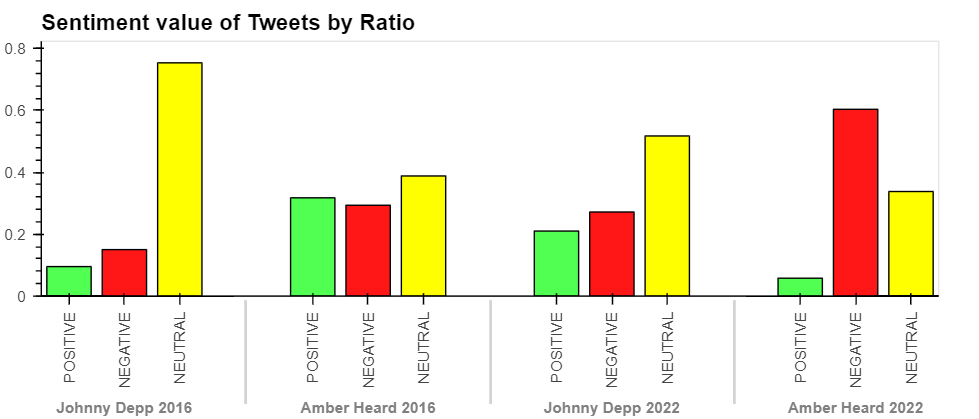

### WordCloud and colour functions

Let us now do some further data exploration. I would like to gain deeper insights into the reactions of the public for events that did not favour either of the celebrity. Specifically, I would like to find out what the positive tweets are talking about by visualising them onto a WordCloud. I am interested in why positive tweets were still made about the celebrity in concern even when the news coverage was not in their favour. Was it tweets solely made by the loyal fans? Or did they know something not known to the public about the events that unfolded? The following functions below provides various unique word plot colours. Below those functions is the function that generates the WordCloud using the colour functions as well as the corpus. [[3]](#ref-3)

In [128]:
import random
from palettable.colorbrewer.sequential import Greens_9, Greys_9, Oranges_9, PuRd_9, Blues_9
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(Greys_9.colors[random.randint(2,8)])

def blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(Blues_9.colors[random.randint(2,8)])

def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(Greens_9.colors[random.randint(2,8)])

def orange_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(Oranges_9.colors[random.randint(2,8)])

def PuRd_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(PuRd_9.colors[random.randint(2,8)])

def produce_wordcloud(corpus, title, mask, color):
    plt.figure(figsize=(20, 10))
#     corpus=dataframe.values.tolist()
#     corpus=','.join(x  for list_words in corpus for x in list_words)
    wordcloud = WordCloud(max_font_size=None, max_words = 300, background_color='black', collocations=False,
                 mask = mask, width=2000, height=1000).generate(corpus)
    wordcloud.recolor(color_func=color)
    plt.axis("off")
    plt.title(title)    
    return plt.imshow(wordcloud, interpolation='bilinear')

In [131]:
# compiling all positive tweets of johnny depp around may 2016
df_johnny_2016_positive = df_dict['johnny depp 2016'][df_dict['johnny depp 2016']['sentiment_label']=='POSITIVE']
johnny_positive_comments_2016 = " ".join(comment for comment in df_johnny_2016_positive.Text)

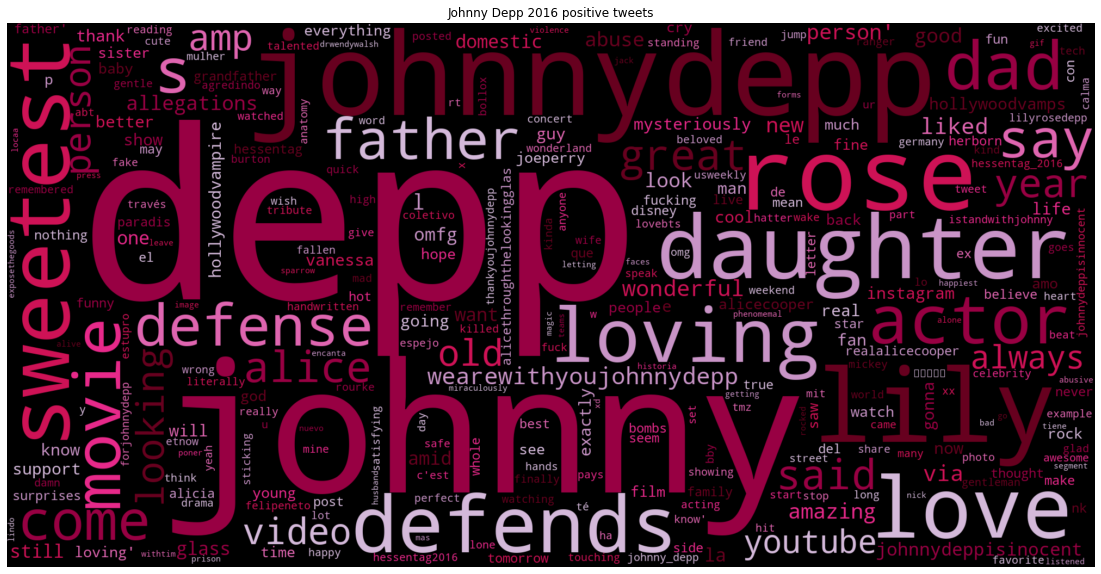

In [130]:
produce_wordcloud(johnny_positive_comments_2016, "Johnny Depp 2016 positive tweets", None, PuRd_color_func)

From a glance, the words that I picked up immediately were 'daughter', 'father' and 'loving'. It seems that there was a decent number of tweets that believe in Johnny Depp on the basis that he is a loving father and that such a man could never be capable of violence as alleged by Amber Heard. This WordCloud gives me the impression that the public feels that Johnny Depp is a family-oriented person.

In [132]:
# compiling all positive tweets of amber heard around june 2022
df_amber_2022_positive = df_dict['amber heard 2022'][df_dict['amber heard 2022']['sentiment_label']=='POSITIVE']
amber_positive_comments_2022 = " ".join(comment for comment in df_amber_2022_positive.Text)

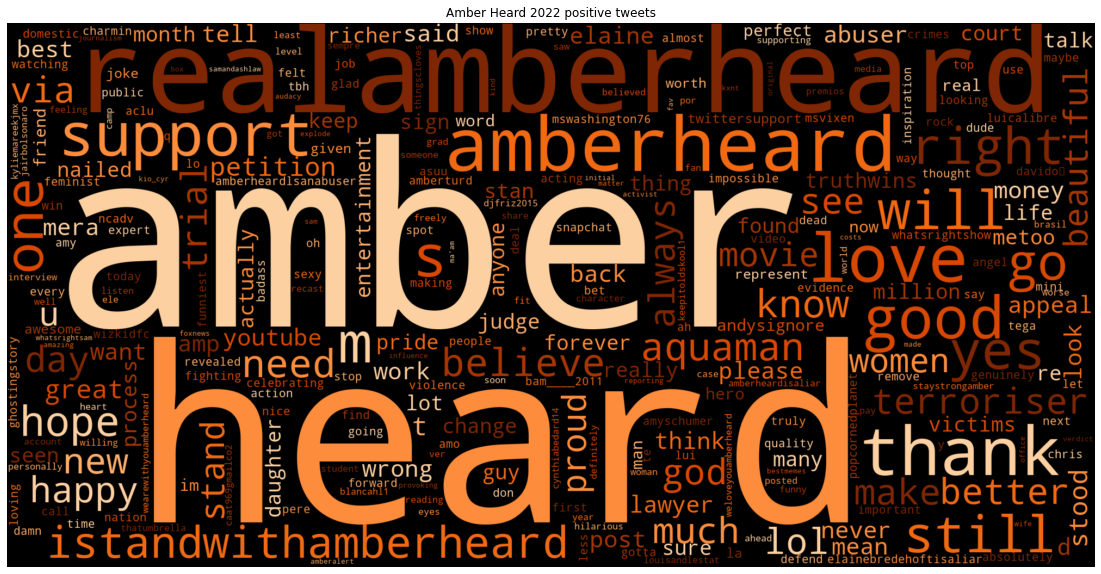

In [133]:
produce_wordcloud(amber_positive_comments_2022, "Amber Heard 2022 positive tweets", None, orange_color_func)

After taking a few glances at the WordCloud above for Amber Heard 2022, there does not seem to be much of a trend here. The words found in the WordCloud have little to no relevance with one another. I am unable to draw a conclusion on the public opinion.

### N-gram analysis
Here, I am interested in finding out the words that appear together very often in tweets. This could provide me with clues as to what the crowd has to say about the celebrity during a certain period. An n-gram is a contiguous sequence of n items from a given sample of text or speech. In the code cells below, I will first extract the contents of every key into another variable to be analysed. [[4]](#ref-4)

In [172]:
df_johnny_ngram_2016 = df_dict['johnny depp 2016']
df_johnny_ngram_2022 = df_dict['johnny depp 2022']
df_amber_ngram_2016 = df_dict['amber heard 2016']
df_amber_ngram_2022 = df_dict['amber heard 2022']

In [197]:
stoplist = stopwords.words('english') + ['cum']
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3))

# function implementation for ngram analysis
def ngram_analysis(df):
    # matrix of ngrams
    ngrams = c_vec.fit_transform(df['Text'])
    # count frequency of ngrams
    count_values = ngrams.toarray().sum(axis=0)
    # list of ngrams
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
                ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
    return df_ngram

The analysis below shows the frequency of bigrams/trigrams that appear the most for Johnny Depp in May 2016. It seems to be mostly about the movie that he has starred in which was "Alice through the looking glass".

In [170]:
ngram_analysis(df_johnny_ngram_2016).head(10)

,frequency,bigram/trigram
0,3949,johnny depp
1,701,alice looking
2,694,looking glass
3,693,alice looking glass
4,525,looking glass bombs
5,525,glass bombs
6,510,vanessa paradis
7,457,bombs worldwide
8,456,worldwide shadow looms
9,456,worldwide shadow


The analysis below shows the frequency of bigrams/trigrams that appear the most for Johnny Depp in June 2022. It seems there are no real trends that I can pick up from this analysis. Perhaps with further data processing and stopwords removal, I  might see a pattern.

In [171]:
ngram_analysis(df_johnny_ngram_2022).head(10)

,frequency,bigram/trigram
0,2199,johnny depp
1,117,de johnny
2,115,de johnny depp
3,58,johnny depp trial
4,58,depp trial
5,51,via youtube
6,50,el juicio
7,38,que johnny
8,38,jack sparrow
9,37,que johnny depp


The analysis below shows the frequency of bigrams/trigrams that appear the most for Amber Heard in May 2016. It looks like smile and lawyer is very common in all the tweets about Amber Heard. A guess would be that either Amber was seen smiling at her lawyer in photos or she was just smiling.

In [179]:
ngram_analysis(df_amber_ngram_2016).head(10)

,frequency,bigram/trigram
0,1371,amber heard
1,399,heard smiles
2,398,amber heard smiles
3,276,pow wow
4,274,smiles lawyer pow
5,274,smiles lawyer
6,274,lawyer pow
7,273,lawyer pow wow
8,273,heard smiles lawyer
9,266,wow photos


The analysis below shows the frequency of bigrams/trigrams that appear the most for Amber Heard in June 2022. Similar to the n-gram of Johnny Depp 2022, I could not discern a topic or focus. 

In [198]:
ngram_analysis(df_amber_ngram_2022).head(10)

,frequency,bigram/trigram
0,1851,amber heard
1,71,terroriser realamberheard
2,55,via youtube
3,55,like amber
4,54,de amber
5,52,de amber heard
6,50,like amber heard
7,45,wanderingjew90 jcndeadpizza6 karmatimebitch
8,45,wanderingjew90 jcndeadpizza6
9,45,karmatimebitch cenkuygur anakasparian


### Topic modelling
To gather more context about the tweets in general, we can also do topic modelling for textual analysis. This basically allows us to generate the topics that the tweets are talking about in general. To do so, I will be using an NMF model or, Non-Negative Matrix Factorization which is a matrix decomposition method that decomposes a matrix into the product of W and H of non-negative elements. The default method optimizes the distance between the original matrix and WH. I will then pass the output down a pipeline along with scikit-learn's TF-IDF vectorizer to convert my texts into a matrix.

In [188]:
# function implementation for printing out the topics
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [191]:
# function implementation for modelling the topics
def topic_model(df):
    tfidf_vectorizer = TfidfVectorizer(stop_words=stoplist, ngram_range=(2,3))
    nmf = NMF(n_components=5)
    pipe = make_pipeline(tfidf_vectorizer, nmf)
    pipe.fit(df['Text'])
    print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=5)

In [193]:
topic_model(df_johnny_ngram_2016)

Topic #0: bombs worldwide shadow, worldwide shadow looms, shadow looms, looms johnny depp, looms johnny
Topic #1: depp domestic, johnny depp domestic, depp domestic abuse, domestic abuse allegations, domestic abuse
Topic #2: depp steps lily, rose depp vanessa, steps lily, steps lily rose, johnny depp steps
Topic #3: depp daughter defends, daughter defends, defends abuse allegations, defends abuse, daughter defends abuse
Topic #4: office johnny, box office johnny, office johnny depp, depp legal woes, johnny depp legal



D:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [194]:
topic_model(df_johnny_ngram_2022)

D:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic #0: johnny depp, johnny depp trial, depp trial, via youtube, de johnny
Topic #1: embolden others lawyers, could embolden, others lawyers, embolden others, could embolden others
Topic #2: 000 legal, 86 000 legal, yes aclu, fees johnny depp, fees johnny
Topic #3: una discusión, una discusión una, discusión una mujer, discusión una, una mujer
Topic #4: depp victory kerry, victory kerry, metoo dead supporter, metoo dead, jennifer aniston likes



In [195]:
topic_model(df_amber_ngram_2016)

D:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic #0: lawyer pow, smiles lawyer pow, smiles lawyer, lawyer pow wow, heard smiles lawyer
Topic #1: heard smiles meeting, smiles meeting lawyers, smiles meeting, meeting lawyers, meeting lawyers actress
Topic #2: heard crying, amber heard crying, wow photos amber, photos amber heard, crying eyes
Topic #3: social media, reacting amber, social media reacting, media reacting amber, media reacting
Topic #4: tasya van ree, married former love, changed last name, tasya van, van ree even



D:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [196]:
topic_model(df_amber_ngram_2022)

D:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic #0: amber heard, via youtube, amber heard aquaman, heard aquaman, remove amber heard
Topic #1: danabrams realamberheard, jcndeadpizza6 karmatimebitch, wanderingjew90 jcndeadpizza6, wanderingjew90 jcndeadpizza6 karmatimebitch, dale2slick wanderingjew90 jcndeadpizza6
Topic #2: others follow, verdict travesty, travesty others follow, travesty others, heard verdict travesty
Topic #3: amber heard puede, planea recurrir, la indemnización, pagar la indemnización, la indemnización planea
Topic #4: terrified attempts silence, sends chilling, message victims abuse, abuse terrified attempts, abuse terrified



## Conclusion
The data exploration has given me a few insights into the things that the public was talking about during the divorce event in 2016 as well as the trial verdict in 2022. The ratio of positive to negative tweets for Johnny Depp remained mostly unchanged with negative tweets still being higher than positive tweets. However, the number of negative tweets for Amber Heard skyrocketed after the trial in 2022. Moving on to the other analysis, I was unable to make a proper conclusion due to the seemingly random nature of the words. This brings up the limitations of the current dataset and model that I am using. Sarcasm could be one of the factors that attribute to the limitations. Comparing my dataset with other sources such as Instagram or Youtube might be able to provide me with a clearer and more accurate description of the sentiments of the public. This could be used for future data analysis on this topic.

## References
<a id="ref-1">[1] https://www.insider.com/johnny-depp-amber-heard-relationship-timeline-2020-7</a> <br>
<a id="ref-2">[2] https://sophiamyang.medium.com/johnny-depp-v-amber-heard-twitter-sentiment-analysis-baa42c2e3cdd</a> <br>
<a id="ref-3">[3] https://www.kaggle.com/code/hoshi7/nyc-jobs-interactive-maps-and-creative-wordclouds</a> <br>
<a id="ref-4">[4] https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5</a>